In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

from dustmaps.sfd import SFDQuery
from helpers import get_ext, fig_path

## Config:

In [2]:
pt_thresh = 8

lite_ptstyle = dict(marker='.', ls='none', alpha=0.2, color='k')

dark_ptstyle = dict(marker='o', markersize=3, markeredgewidth=0,
                    ls='none', alpha=0.5, color='k', rasterized=True)

pcolor_style = dict(cmap='copper', rasterized=True, linewidth=0)

---

In [4]:
cluster_c = coord.SkyCoord(ra=179.5*u.deg,
                           dec=-28.8*u.deg)
cluster_c.galactic

<SkyCoord (Galactic): (l, b) in deg
    ( 289.02118741,  32.62416777)>

In [12]:
g = GaiaData('../data/data-joined.fits')
c = g.get_skycoord(distance=False)

near_cluster = c.separation(cluster_c) < 3*u.deg
g = g[near_cluster]
c = c[near_cluster]

mag_c = c.transform_to(gc.MagellanicStream)

In [13]:
mist_isos = []
parsec_isos = []
fehs = [-1.5, -0.5]
lses = ['-', '--']

for feh in fehs:
    fn = '/Users/adrian/data/Isochrones/MIST/FeH_{:.1f}_iso.fits'.format(feh)
    all_iso = Table.read(fn)
    iso = all_iso[np.isclose(all_iso['log10_isochrone_age_yr'], 7.7)]
    iso = iso[np.isin(iso['phase'], [0])]
    mist_isos.append(iso)
    
    fn = '/Users/adrian/data/Isochrones/PARSEC/FeH_{:.1f}_iso.fits'.format(feh)
    all_iso = Table.read(fn)
    iso = all_iso[np.isclose(all_iso['log(age/yr)'], 7.7)]
    iso = iso[np.isin(iso['stage'], [1])]
    parsec_isos.append(iso)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


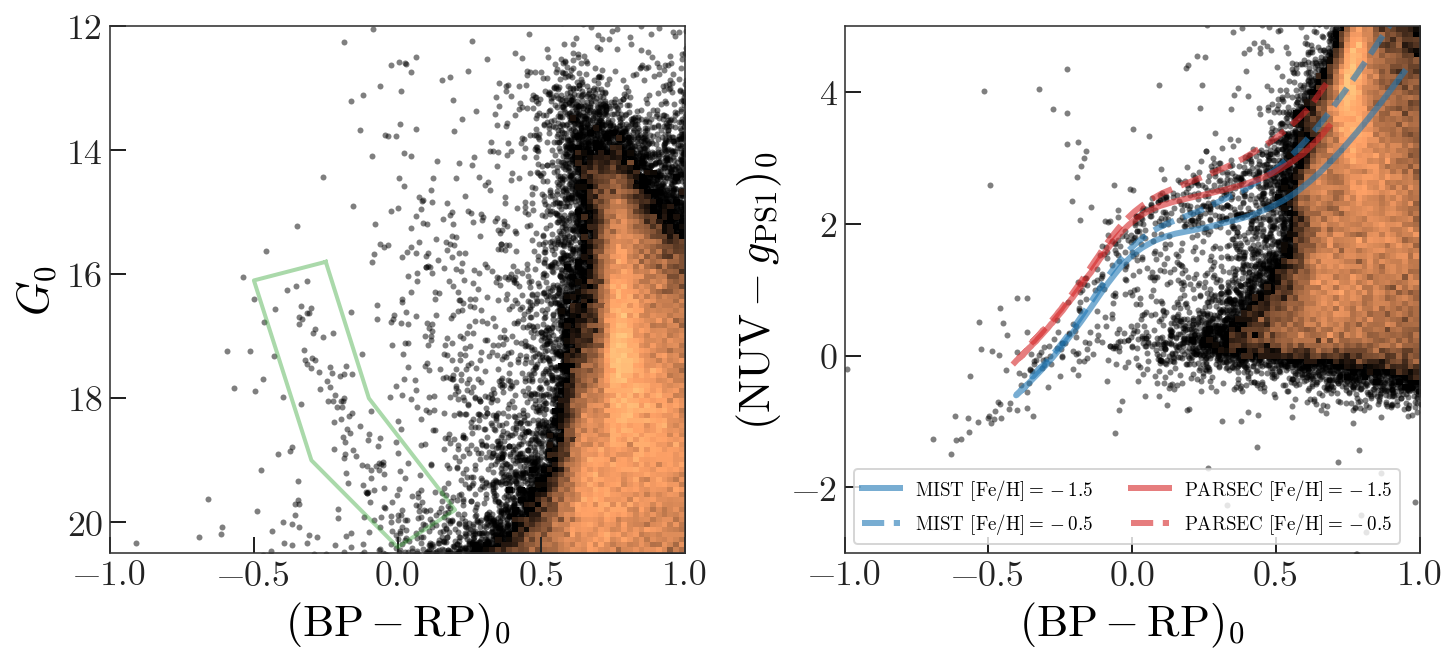

In [15]:
col_binsize = 0.02
mag_binsize = 0.08
norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=1e2)

def make_panel(ax, col, mag, col_lim, mag_lim,
               col_label, mag_label, flipy=True):
    H, xe, ye = np.histogram2d(col, mag,
                               bins=(np.arange(col_lim[0], col_lim[1]+1e-3, col_binsize),
                                     np.arange(mag_lim[0], mag_lim[1]+1e-3, mag_binsize)))

    H[H < pt_thresh] = np.nan
    m = ax.pcolormesh(xe, ye, H.T, 
                      norm=norm, label='', 
                      **pcolor_style)
    ax.plot(col, mag, 
            zorder=-10, label='', **dark_ptstyle)
    ax.set_xlim(col_lim)
    
    if flipy:
        ax.set_ylim(mag_lim[::-1])
    else:
        ax.set_ylim(mag_lim)
    
    ax.set_xlabel(col_label)
    ax.set_ylabel(mag_label)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), 
                         constrained_layout=True)

make_panel(axes[0],
           col=g.BP0-g.RP0,
           mag=g.G0,
           col_lim=(-1, 1),
           mag_lim=(12, 20.5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$G_0$')

NUV = g.NUV0.copy()
NUV[g.galex_NUV == 20.565] = np.nan
make_panel(axes[1],
           col=g.BP0-g.RP0,
           mag=NUV-g.g0,
           col_lim=(-1, 1),
           mag_lim=(-3, 5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$({\rm NUV}-g_{\rm PS1})_0$',
           flipy=False)

nodes = np.array([[-0.25, 15.8],
                  [-0.1, 18.],
                  [0.2, 19.8],
                  [0.0, 20.4],
                  [-0.3, 19.],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
axes[0].plot(nodes[:, 0], nodes[:, 1], 
             marker='', color='tab:green', lw=2, alpha=0.4)

for iso, feh, ls in zip(mist_isos, fehs, lses):
#     axes[0].plot(iso['G_BP'] - iso['G_RP'], 
#                  iso['G'] + coord.Distance(30*u.kpc).distmod.value, 
#                  marker='')
    axes[1].plot(iso['G_BP'] - iso['G_RP'], 
                 iso['NUV'] - iso['ps1_g'], 
                 marker='', linewidth=3, ls=ls,
                 alpha=0.6, color='tab:blue',
                 label=r'MIST $[{\rm Fe}/{\rm H}] =' + ' {:.1f}$'.format(feh))
    
for iso, feh, ls in zip(parsec_isos, fehs, lses):
#     axes[0].plot(iso['G_BP'] - iso['G_RP'], 
#                  iso['G'] + coord.Distance(30*u.kpc).distmod.value, 
#                  marker='')
    axes[1].plot(iso['G_BP'] - iso['G_RP'], 
                 iso['NUV'] - iso['ps1_g'], 
                 marker='', linewidth=3, ls=ls,
                 alpha=0.6, color='tab:red',
                 label=r'PARSEC $[{\rm Fe}/{\rm H}] =' + ' {:.1f}$'.format(feh))
    
axes[1].legend(loc='lower left', fontsize=9.5, ncol=2)

fig.savefig(fig_path / 'gaia-galex-cmd.pdf', dpi=250)